In [1]:
import os
import gc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
import xgboost as xgb

In [2]:
SEED = 42
NAN_VALUE = -127    # will fit in int8
FOLDS = 5

TRAIN_PATH = './data/train.parquet'
TEST_PATH = './data/test.parquet'

##### Process and Feature Engineer Train Data

In [3]:
def read_file(path='', usecols=None):
    if usecols is not None:
        df = pd.read_parquet(path, columns=usecols)
    else:
        df = pd.read_parquet(path)

    # df['customer_ID'] = df['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
    # df['customer_ID'] = df['customer_ID'].str[-16:].apply(int, base=16).astype('int64')
    df['customer_ID'] = df['customer_ID'].apply(lambda x: int(x[-16:], base=16)).astype('int64')
    df['S_2'] = pd.to_datetime(df['S_2'])
    df = df.fillna(NAN_VALUE)
    print('shape of data:', df.shape)

    return df

print('Reading train data...')
train = read_file(path=TRAIN_PATH)

Reading train data...
shape of data: (5531451, 190)


In [4]:
train.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,-4532153018459703766,2017-03-09,0.938469,0,0.008724,1.006838,0.009228,0.124035,0.0,0.004709,...,-1,-1,-1,0,0,0.0,-127.0,0,0.000610,0
1,-4532153018459703766,2017-04-07,0.936665,0,0.004923,1.000653,0.006151,0.126750,0.0,0.002714,...,-1,-1,-1,0,0,0.0,-127.0,0,0.005492,0
2,-4532153018459703766,2017-05-28,0.954180,3,0.021655,1.009672,0.006815,0.123977,0.0,0.009423,...,-1,-1,-1,0,0,0.0,-127.0,0,0.006986,0
3,-4532153018459703766,2017-06-13,0.960384,0,0.013683,1.002700,0.001373,0.117169,0.0,0.005531,...,-1,-1,-1,0,0,0.0,-127.0,0,0.006527,0
4,-4532153018459703766,2017-07-16,0.947248,0,0.015193,1.000727,0.007605,0.117325,0.0,0.009312,...,-1,-1,-1,0,0,0.0,-127.0,0,0.008126,0


In [5]:
def process_and_feature_engineer(df):
    all_cols = [c for c in list(df.columns) if c not in ['customer_ID', 'S_2']]
    cat_features = [
        "B_30", "B_38", "D_114", "D_116", "D_117", "D_120", "D_126", "D_63",
        "D_64","D_66", "D_68"
    ]
    num_features = [col for col in all_cols if col not in cat_features]

    df_num_agg = df.groupby('customer_ID')[num_features].agg(['mean', 'std', 'min', 'max', 'last'])
    df_num_agg.columns = ['_'.join(x) for x in df_num_agg.columns]

    df_cat_agg = df.groupby('customer_ID')[cat_features].agg(['count', 'last', 'nunique'])
    df_cat_agg.columns = ['_'.join(x) for x in df_cat_agg.columns]

    df = pd.concat([df_num_agg, df_cat_agg], axis=1)
    del df_num_agg, df_cat_agg
    gc.collect()
    print('shape after engineering', df.shape)

    return df

train = process_and_feature_engineer(train)

shape after engineering (458913, 918)


In [6]:
targets = pd.read_csv('./data/train_labels.csv')
targets['customer_ID'] = targets['customer_ID'].str[-16:].apply(int, base=16).astype('int64')
targets = targets.set_index('customer_ID')
train = train.merge(targets, left_index=True, right_index=True, how='left')
train['target'] = train['target'].astype('int8')
del targets
gc.collect()

train = train.sort_index().reset_index()
FEATURES = train.columns[1:-1]
print(f'There are {len(FEATURES)} features!')

There are 918 features!


##### Train XGB

In [7]:
xgb_parms = { 
    'max_depth': 4, 
    'learning_rate': 0.05, 
    'subsample': 0.8,
    'colsample_bytree': 0.6, 
    'eval_metric': 'logloss',
    'objective': 'binary:logistic',
    'tree_method': 'gpu_hist',
    'predictor': 'gpu_predictor',
    'random_state': SEED
}

In [8]:
class IterLoadForDMatrix(xgb.core.DataIter):
    def __init__(self, df=None, features=None, target=None, batch_size=256 * 1024):
        self.features = features
        self.target = target
        self.df = df
        self.i = 0
        self.batch_size = batch_size
        self.batches = int(np.ceil(len(df) / self.batch_size))
        super().__init__()

    def reset(self):
        self.it = 0

    def next(self, input_data):
        if self.it == self.batches:
            return 0

        a = self.it * self.batch_size
        b = min((self.it + 1) * self.batch_size, len(self.df))
        dt = pd.DataFrame(self.df.iloc[a:b])
        input_data(data=dt[self.features], label=dt[self.target])
        self.it += 1
        return 1

In [9]:
def amex_metric_mod(y_true, y_pred):
    labels = np.transpose(np.array([y_true, y_pred]))
    labels = labels[labels[:, 1].argsort()[::-1]]
    weights = np.where(labels[:, 0] == 0, 20, 1)
    cut_vals = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four = np.sum(cut_vals[:, 0]) / np.sum(labels[:, 0])

    gini = [0, 0]
    for i in [1, 0]:
        labels = np.transpose(np.array([y_true, y_pred]))
        labels = labels[labels[:, i].argsort()[::-1]]
        weight = np.where(labels[:, 0] == 0, 20, 1)
        weight_random = np.cumsum(weight / np.sum(weight))
        total_pos = np.sum(labels[:, 0] *  weight)
        cum_pos_found = np.cumsum(labels[:, 0] * weight)
        lorentz = cum_pos_found / total_pos
        gini[i] = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1] / gini[0] + top_four)

In [10]:
importances = []
oof = []
TRAIN_SUBSAMPLE = 1.0
gc.collect()

skf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for fold, (train_idx, valid_idx) in enumerate(skf.split(train, train.target)):
    # Train with subsample of train fold data
    if TRAIN_SUBSAMPLE < 1.0:
        np.random.seed(SEED)
        train_idx = np.random.choice(train_idx, int(len(train_idx) * TRAIN_SUBSAMPLE), replace=False)
        np.random.seed(None)

    print('#' * 25)
    print('### Fold', fold + 1)
    print('### Train size', len(train_idx), 'Valid size', len(valid_idx))
    print(f'### Training with {int(TRAIN_SUBSAMPLE * 100)} % fold data...')
    print('#' * 25)

    # train, valid, test for fold k
    # Xy_train = IterLoadForDMatrix(train.loc[train_idx], FEATURES, 'target')
    X_train = train.loc[train_idx, FEATURES]
    y_train = train.loc[train_idx, 'target']
    X_valid = train.loc[valid_idx, FEATURES]
    y_valid = train.loc[valid_idx, 'target']

    # dtrain = xgb.DeviceQuantileDMatrix(Xy_train, max_bin=256)
    dtrain = xgb.DMatrix(data=X_train, label=y_train)
    dvalid = xgb.DMatrix(data=X_valid, label=y_valid)

    # train model fold k
    model = xgb.train(
        xgb_parms,
        dtrain=dtrain,
        evals=[(dtrain, 'train'), (dvalid, 'valid')],
        num_boost_round=9999,
        early_stopping_rounds=100,
        verbose_eval=100
    )
    model.save_model(f'XGB_fold{fold}.xgb')

    # get feature importance for fold k
    dd = model.get_score(importance_type='weight')
    df = pd.DataFrame({'feature': dd.keys(), f'importance_{fold}': dd.values()})
    importances.append(df)

    # infer oof fold k
    oof_preds = model.predict(dvalid)
    acc = amex_metric_mod(y_valid.values, oof_preds)
    print('Kaggle Metric = ', acc, '\n')

    # save oof
    df = train.loc[valid_idx, ['customer_ID', 'target']].copy()
    df['oof_pred'] = oof_preds
    oof.append(df)

    del dtrain, dd, df
    del X_train, y_train, X_valid, y_valid, dvalid, model
    gc.collect()

print('#' * 25)
oof = pd.concat(oof, axis=0, ignore_index=True).set_index('customer_ID')
acc = amex_metric_mod(oof.target.values, oof.oof_pred.values)
print('OVERALL CV Kaggle Metric = ', acc)

with open('score_xgboost.txt', 'w') as f:
    f.write(str(acc))

#########################
### Fold 1
### Train size 367130 Valid size 91783
### Training with 100 % fold data...
#########################
[0]	train-logloss:0.66203	valid-logloss:0.66207
[100]	train-logloss:0.23667	valid-logloss:0.23947
[200]	train-logloss:0.22241	valid-logloss:0.22761
[300]	train-logloss:0.21639	valid-logloss:0.22360
[400]	train-logloss:0.21240	valid-logloss:0.22157
[500]	train-logloss:0.20917	valid-logloss:0.22034
[600]	train-logloss:0.20641	valid-logloss:0.21948
[700]	train-logloss:0.20395	valid-logloss:0.21886
[800]	train-logloss:0.20173	valid-logloss:0.21843
[900]	train-logloss:0.19954	valid-logloss:0.21813
[1000]	train-logloss:0.19750	valid-logloss:0.21793
[1100]	train-logloss:0.19543	valid-logloss:0.21770
[1200]	train-logloss:0.19352	valid-logloss:0.21759
[1300]	train-logloss:0.19164	valid-logloss:0.21742
[1400]	train-logloss:0.18986	valid-logloss:0.21731
[1500]	train-logloss:0.18811	valid-logloss:0.21725
[1600]	train-logloss:0.18631	valid-logloss:0.21721
[1700]

In [11]:
del train
gc.collect()

20

##### Save OOF Preds

In [12]:
oof_xgb = pd.read_parquet(TRAIN_PATH, columns=['customer_ID']).drop_duplicates()
oof_xgb['customer_ID_hash'] = oof_xgb['customer_ID'].apply(lambda x: int(x[-16:], 16)).astype('int64')
oof_xgb = oof_xgb.set_index('customer_ID_hash')
oof_xgb = oof_xgb.merge(oof, left_index=True, right_index=True)
oof_xgb = oof_xgb.sort_index().reset_index(drop=True)
oof_xgb.to_csv(f'oof_xgb.csv', index=False)
oof_xgb.head()

,customer_ID,target,oof_pred
0,20eac26171c3d251c55fc78204e59fab1c15fc2bc96d0c...,1,0.728655
1,aea50fdf9b974ccec95fa177c3225a0f913483b457de6e...,0,0.000318
2,32cd2d41aef737b69089882754395925c96eaee1f4a859...,0,0.002138
3,8daa6d5dc2655a8a437531e6b8b96829113cdfe9bf6cae...,0,0.014430
4,0ceba351a3851202542feb49d7385bcef32f6037fc57c7...,1,0.834159


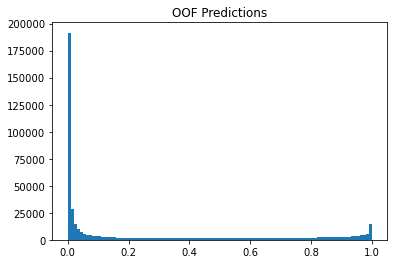

In [13]:
plt.hist(oof_xgb.oof_pred.values, bins=100)
plt.title('OOF Predictions')
plt.show()

In [14]:
del oof_xgb, oof
gc.collect()

10483

##### Feature Importance

In [15]:
df = importances[0].copy()
for k in range(1, FOLDS):
    df = df.merge(importances[k], on='feature', how='left')
    df['importance'] = df.iloc[:, 1:].mean(axis=1)
    df = df.sort_values('importance', ascending=False)
    df.to_csv(f'xgb_feature_importance.csv', index=False)

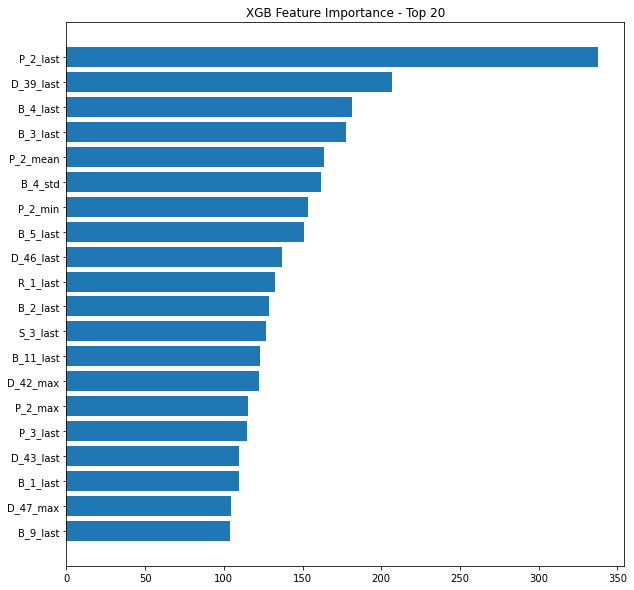

In [16]:
NUM_FEATURES = 20
plt.figure(figsize=(10, 5 * NUM_FEATURES // 10))
plt.barh(np.arange(NUM_FEATURES, 0, -1), df.importance.values[:NUM_FEATURES])
plt.yticks(np.arange(NUM_FEATURES, 0, -1), df.feature.values[:NUM_FEATURES])
plt.title(f'XGB Feature Importance - Top {NUM_FEATURES}')
plt.show()

##### Process and Feature Engineer Test data

In [17]:
def get_rows(customers, test, NUM_PARTS=4, verbose=''):
    chunk = len(customers) // NUM_PARTS
    if verbose != '':
        print(f'We will process {verbose} data as {NUM_PARTS} separate parts.')
        print(f'There will be {chunk} customers in each part (except the last part).')
        print('Below are number of rows in each part:')
    rows = []

    for k in range(NUM_PARTS):
        if k == NUM_PARTS - 1:
            cc = customers[k * chunk:]
        else:
            cc = customers[k * chunk:(k + 1) * chunk]
        s = test.loc[test.customer_ID.isin(cc)].shape[0]
        rows.append(s)
    if verbose != '':
        print(rows)
    return rows, chunk

NUM_PARTS = 4

print(f'Reading test data...')
test = read_file(path=TEST_PATH, usecols=['customer_ID', 'S_2'])
customers = test[['customer_ID']].drop_duplicates().sort_index().values.flatten()
rows, num_cust = get_rows(customers, test[['customer_ID']], NUM_PARTS=NUM_PARTS, verbose='test')

Reading test data...
shape of data: (11363762, 2)
We will process test data as 4 separate parts.
There will be 231155 customers in each part (except the last part).
Below are number of rows in each part:
[2841209, 2839857, 2842105, 2840591]


##### Infer Test

In [18]:
skip_rows = 0
skip_cust = 0
test_preds = []

for k in range(NUM_PARTS):
    # read part of test data
    print(f'\nReading test data...')
    test = read_file(path=TEST_PATH)
    test = test.iloc[skip_rows:skip_rows + rows[k]]
    skip_rows += rows[k]
    print(f'=> Test part {k + 1} has shape', test.shape)
    
    # process and feature engineer part of test data
    test = process_and_feature_engineer(test)
    if k == NUM_PARTS - 1:
        test = test.loc[customers[skip_cust:]]
    else:
        test = test.loc[customers[skip_cust:skip_cust + num_cust]]
    skip_cust += num_cust

    # test data for xgb
    X_test = test[FEATURES]
    dtest = xgb.DMatrix(data=X_test)
    test = test[['P_2_mean']]
    del X_test
    gc.collect()

    # infer xgb models on test data
    model = xgb.Booster()
    model.load_model(f'XGB_fold0.xgb')
    preds = model.predict(dtest)
    for f in range(1, FOLDS):
        model.load_model(f'XGB_fold{f}.xgb')
        preds += model.predict(dtest)
    preds /= FOLDS
    test_preds.append(preds)

    del dtest, model
    gc.collect()


Reading test data...
shape of data: (11363762, 190)
=> Test part 1 has shape (2841209, 190)
shape after engineering (231155, 918)

Reading test data...
shape of data: (11363762, 190)
=> Test part 2 has shape (2839857, 190)
shape after engineering (231155, 918)

Reading test data...
shape of data: (11363762, 190)
=> Test part 3 has shape (2842105, 190)
shape after engineering (231155, 918)

Reading test data...
shape of data: (11363762, 190)
=> Test part 4 has shape (2840591, 190)
shape after engineering (231156, 918)


##### Create Submission CSV

In [19]:
test_preds = np.concatenate(test_preds)
test = pd.DataFrame(index=customers, data={'prediction': test_preds})
sub = pd.read_csv('./data/sample_submission.csv')[['customer_ID']]
sub['customer_ID_hash'] = sub['customer_ID'].apply(lambda x: int(x[-16:], base=16)).astype('int64')
sub = sub.set_index('customer_ID_hash')
sub = sub.merge(test[['prediction']], left_index=True, right_index=True, how='left')
sub = sub.reset_index(drop=True)

# display predictions
sub.to_csv(f'submission_xgboost.csv', index=False)
print('Submission file shape is', sub.shape)
sub.head()

Submission file shape is (924621, 2)


,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.035222
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.001085
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.088275
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.248362
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.841283
